In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()
from time import time

## Ice Cream production data

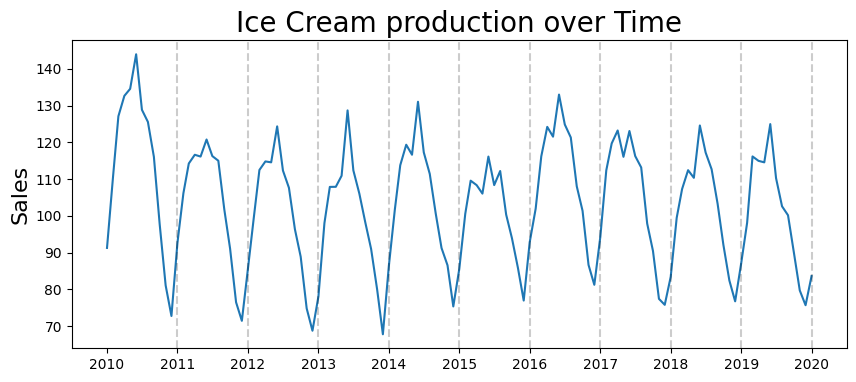

In [28]:
import os
production_ice_cream = pd.read_csv(os.path.join(os.getcwd(), 'data/ice_cream.csv'), 
                            index_col=0) # index_col = 0 indicates that we are using first col for indexing
# Convert the index to datetime format if needed
production_ice_cream.index = pd.to_datetime(production_ice_cream.index)
production_ice_cream = production_ice_cream.asfreq(pd.infer_freq(production_ice_cream.index))


#get data from 2010 onwards
start_date = datetime(2010,1,1)
production_ice_cream = production_ice_cream[start_date:]



plt.figure(figsize=(10,4))
plt.plot(production_ice_cream)
plt.title('Ice Cream production over Time', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)



### Plot ACF and PACF

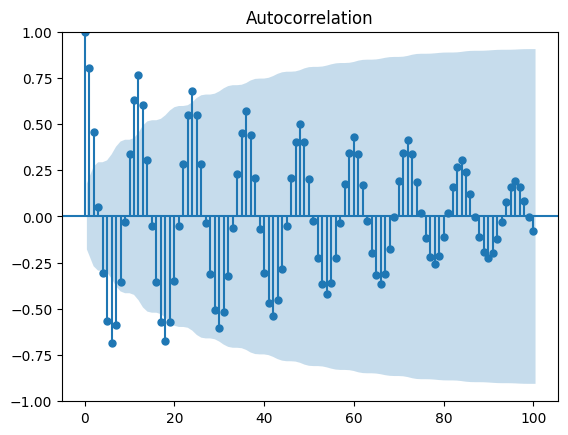

In [3]:
acf_plot = plot_acf(production_ice_cream, lags=100)

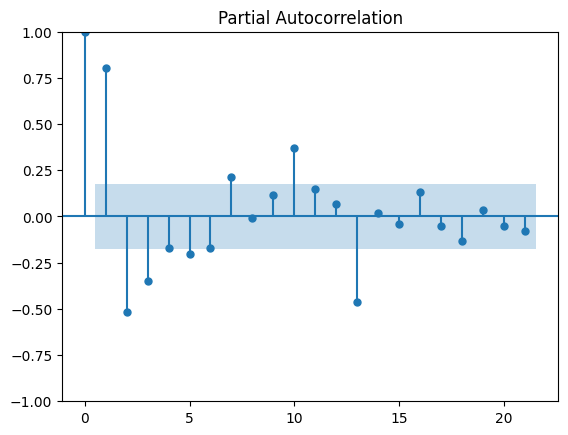

In [4]:
pacf_plot = plot_pacf(production_ice_cream)

### Get training and testing sets

In [96]:
train_end = datetime(2016,12,1) # training: 2010-Jan to 2016-Dec
test_end = datetime(2019,12,1) # testing: 2019-Jan to 2019-Dec 

train_data = production_ice_cream[:train_end]
test_data = production_ice_cream[train_end + timedelta(days=1):test_end]
test_data.tail()

,IPN31152N
DATE,
2019-08-01,102.6085
2019-09-01,100.1741
2019-10-01,90.1684
2019-11-01,79.7223
2019-12-01,75.7094


### Fit the ARMA Model


In [97]:
# define model
model = ARIMA(train_data, order=(3,0,0))

# fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

# summary of the model
print(model_fit.summary())

Model Fitting Time: 0.05510711669921875
                               SARIMAX Results                                
Dep. Variable:              IPN31152N   No. Observations:                   84
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -294.008
Date:                Sun, 20 Oct 2024   AIC                            598.015
Time:                        23:43:04   BIC                            610.169
Sample:                    01-01-2010   HQIC                           602.901
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5071      2.531     40.893      0.000      98.546     108.468
ar.L1          1.0488      0.116      9.046      0.000       0.822       1.276
ar.L2       

phi_2 's p value = 0.765 >> 0.05 hence LAG 2 is not important. Build AR model with LAG 1 and 3 only

In [98]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
pred_end_date

Timestamp('2019-12-01 00:00:00')

In [99]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date) # or use .forecast(steps=x)
residuals = test_data.IPN31152N - predictions

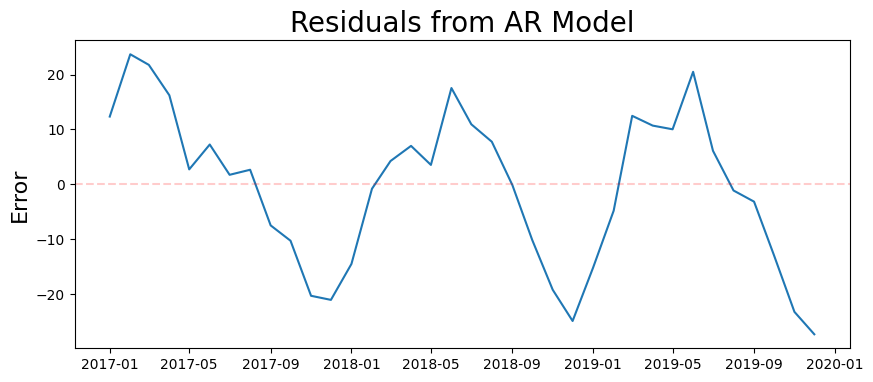

In [100]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Clear pattern in residual indicates failure to capture certain dynamics in the data

Text(0, 0.5, 'Sales')

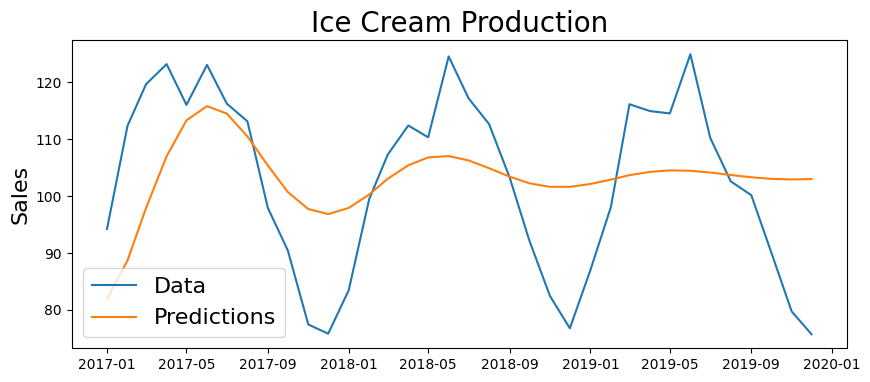

In [101]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Ice Cream Production', fontsize=20)
plt.ylabel('Sales', fontsize=16)

Predictions closer in time to our training set generally follows the trend of the actual data; however as we get to future observations further in time, our prediction become less certain and tends to flatline(prediction follows the mean), which explains the pattern we see in our Residuals Plot.

In [112]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data.IPN31152N)),4))
print("We are 12% away from our actual data using an AR(3) model")

Mean Absolute Percent Error: 0.1211
We are 12% away from our actual data using an AR(3) model


In [103]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))


Root Mean Squared Error: 13.890102326296548


*Conclusion* : For time series prediction, we cannot just apportion out 30% of our data as test_set because this would mean that we are training our model on the first 70%(datetime) of our data and testing it on the rest of our data that falls within the same period of time. This will consequently bias our model's prediction towards data which time period are closer to our train set.

## Rolling Forecast Origin

### Idea: Predict one month in advance each time
#### Train on months 1,2 ... , k-3 -> predict month k-2
#### Train on months 1,2 ... , k-3, k-2 -> predict month k-1
#### Train on months 1,2 ... , k-3, k-2, k-1 -> predict month k
...

#### Average all prediction

## 

In [104]:
#create the model
predictions_rolling = pd.Series()
for end_date in test_data.index:
    train_data = production_ice_cream[:end_date - timedelta(days=1)]
    model = ARIMA(train_data, order=(3,0,0))
    model_fit = model.fit()
    pred = model_fit.predict(start=end_date, end=end_date)
    predictions_rolling.loc[end_date] = pred.iloc[0]   

In [108]:
residuals_rolling = test_data.IPN31152N - predictions_rolling

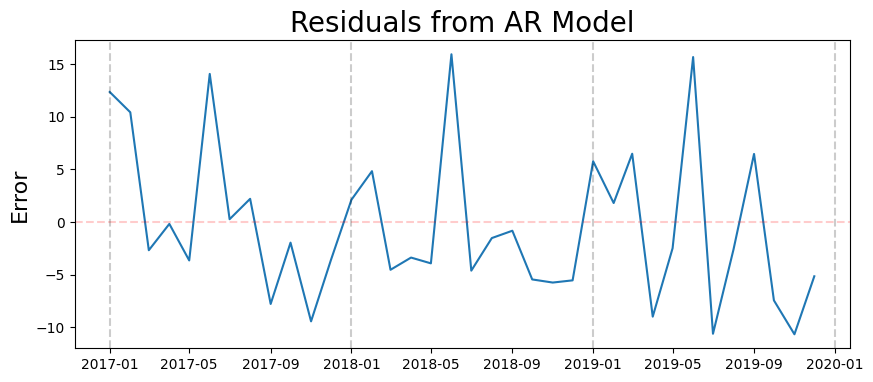

In [110]:
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)
for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

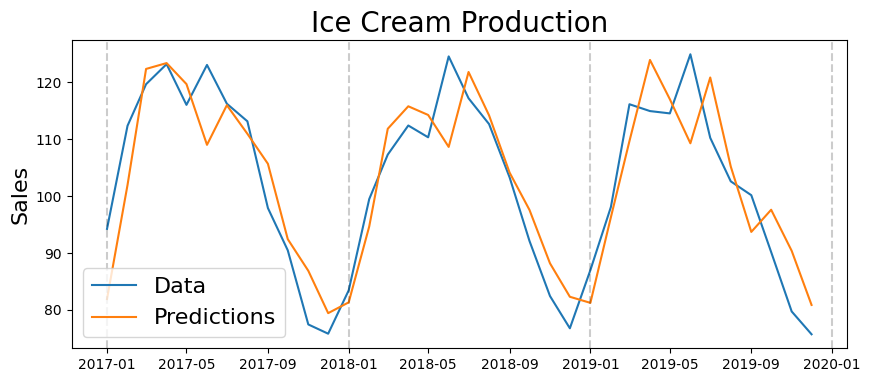

In [111]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions_rolling)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Ice Cream Production', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [117]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals_rolling/test_data.IPN31152N)),4))
print("We are 5% away from our actual data using Rolling Forecast Origin to split our data for training and prediction")

Mean Absolute Percent Error: 0.0582
We are 5% away from our actual data using Rolling Forecast Origin to split our data for training and prediction


In [116]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_rolling**2)))

Root Mean Squared Error: 7.1965136322595304


##### Caveat: We need to fit the model every to predict the next month. e.g. fit model with sales up till June to predict sales for July (1 period in advance). Predicting sales for next month is much more accurate than predicting sales for next year.